In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import re

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# model = MyModel().to(device)

In [3]:
diagnostics={"NORM":['NORM','CSD'],
             "STTC":['NDT', 'NST_', 'DIG', 'LNGQT', 'ISC_', 'ISCAL', 'ISCIN', 'ISCIL', 'ISCAS', 'ISCLA', 'ANEUR', 'EL', 'ISCAN' ],
             "MI":['IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'INJAS', 'LMI', 'INJAL', 'IPLMI', 'IPMI', 'INJIN', 'INJLA', 'PMI', 'INJIL'],
             "HYP":['LVH', 'LAO/LAE', 'RVH', 'RAO/RAE', 'SEHYP'],
             "CD":['LAFB', 'IRBBB', '1AVB', 'IVCD', 'CRBBB', 'CLBBB', 'LPFB', 'WPW', 'ILBBB', '3AVB', '2AVB'],
             "OTHER":['AFLT', 'AFIB', 'PSVT', 'STACH', 'PVC', 'PACE', 'PAC']
            }

In [4]:
db_path="../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
ecg_data=pd.read_csv(f'{db_path}/ptbxl_database.csv')
ecg_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [5]:
ecg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21799 entries, 0 to 21798
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        21799 non-null  int64  
 1   patient_id                    21799 non-null  float64
 2   age                           21799 non-null  float64
 3   sex                           21799 non-null  int64  
 4   height                        6974 non-null   float64
 5   weight                        9421 non-null   float64
 6   nurse                         20326 non-null  float64
 7   site                          21782 non-null  float64
 8   device                        21799 non-null  object 
 9   recording_date                21799 non-null  object 
 10  report                        21799 non-null  object 
 11  scp_codes                     21799 non-null  object 
 12  heart_axis                    13331 non-null  object 
 13  i

In [6]:
#Merging the diagnosis into a superclass:
labels=[]
discard=[]
for index in range(ecg_data.shape[0]):
    counter=0
    temp_diag=ecg_data['scp_codes'][index]
    temp_diag=re.sub('{',"",str(temp_diag))
    temp_diag=re.sub('}',"",temp_diag)
    temp_diag=temp_diag.split(',')
    len_diag=len(temp_diag)
    for idx in range(len_diag):
        temp_d=temp_diag[idx]
        temp_d=temp_d.split(':')[0]
        temp_d=re.sub(r'[^\w\s]',"",temp_d)

        # 이진분류시 하나뺴고 나머지 레이블을 0또는 1로 변경
        # 이 부분 코드는 자동 학습 코드에 반영되어있지만 수정이 필요할 수 있음
        if temp_d in diagnostics['NORM']:
            label=0
            counter=1
        elif temp_d in diagnostics['STTC']:
            label=1
            counter=1
        elif temp_d in diagnostics['MI']:
            label=2
            counter=1
        elif temp_d in diagnostics['HYP']:
            label=3
            counter=1
        elif temp_d in diagnostics['CD']:
            label=4
            counter=1
        elif temp_d in diagnostics['OTHER']:
            label=5
            counter=1
        else:
            label=100
        labels.append(label)
    if counter==0:
        discard.append(index)

final_labels=[]
for index in range(len(labels)):
    if labels[index]!=100:
        final_labels.append(labels[index])

final_data=ecg_data.drop(axis=0,index=discard)
final_data['Labels']=final_labels
final_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,Labels
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,0
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,0
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,0
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,0
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,0


Labels
0    9514
2    5420
1    2803
4    2321
3    1237
5     425
Name: count, dtype: int64


<Axes: xlabel='Labels', ylabel='count'>

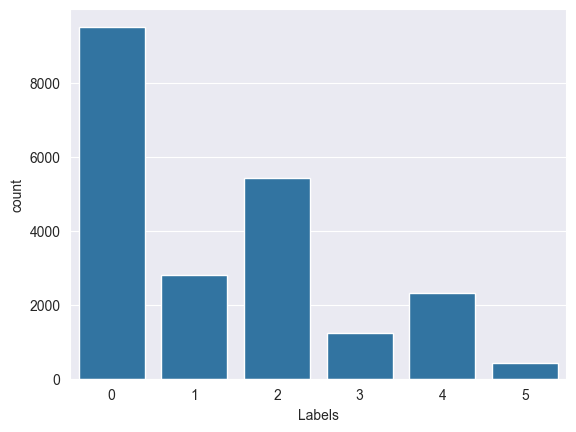

In [7]:
print(final_data['Labels'].value_counts())
sns.countplot(data=final_data,x='Labels')

In [8]:
ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

ECG_train['Labels'].value_counts()  

Labels
0    7596
2    4341
1    2233
4    1839
3    1002
5     346
Name: count, dtype: int64

In [9]:
""" 
ECG_train = ECG_train[ECG_train['Labels'].isin([0,1])].reset_index(drop=True)
ECG_val = ECG_val[ECG_val['Labels'].isin([0,1])].reset_index(drop=True)
ECG_test = ECG_test[ECG_test['Labels'].isin([0,1])].reset_index(drop=True)
"""

ECG_train = ECG_train[ECG_train['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)
ECG_val = ECG_val[ECG_val['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)
ECG_test = ECG_test[ECG_test['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)

ECG_train['Labels'].value_counts()

Labels
0    7596
2    4341
1    2233
4    1839
3    1002
Name: count, dtype: int64

In [10]:
from ver4_journal.common.data.ECG_Data import ECG_Data

# ECG_train=ECG_train.reset_index()
# ECG_test=ECG_test.reset_index()

train_dataset = ECG_Data(ECG_train)
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

val_dataset=ECG_Data(ECG_val)
val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

first_batch, label = next(iter(train_loader))

print(f"Batch shape: {first_batch.shape}")

"""
for i in range(12):
    print(f'channel {i}: {torch.min(first_batch[:, i])}, {torch.max(first_batch[:, i])}')
"""

Batch shape: torch.Size([64, 12, 1000])


"\nfor i in range(12):\n    print(f'channel {i}: {torch.min(first_batch[:, i])}, {torch.max(first_batch[:, i])}')\n"

In [11]:
from ver4_journal.common.data.ECG_Data import ECG_Data

# ECG_train=ECG_train.reset_index()
# ECG_test=ECG_test.reset_index()

train_dataset = ECG_Data(ECG_train)
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

val_dataset=ECG_Data(ECG_val)
val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

first_batch, label = next(iter(train_loader))

print(f"Batch shape: {first_batch.shape}")

"""
for i in range(12):
    print(f'channel {i}: {torch.min(first_batch[:, i])}, {torch.max(first_batch[:, i])}')
"""

Batch shape: torch.Size([64, 12, 1000])


"\nfor i in range(12):\n    print(f'channel {i}: {torch.min(first_batch[:, i])}, {torch.max(first_batch[:, i])}')\n"

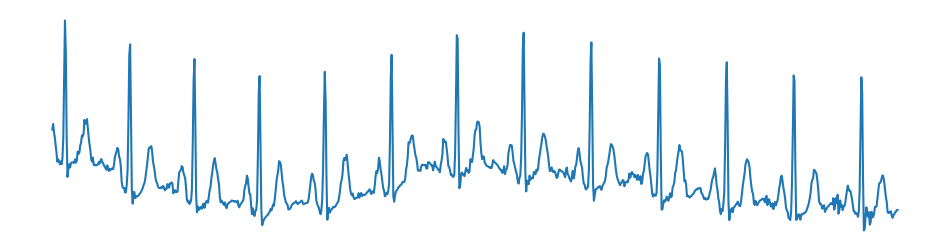

In [12]:
sample = first_batch[0]
plt.figure(figsize=(12,3))
plt.axis(False)
plt.plot(sample[1,:])

In [13]:
len(train_loader), len(val_loader), len(test_loader)

(266, 34, 34)